**Task: Cuisine Classification**

#Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score


In [ ]:
restaurent_data = pd.read_csv('/content/Dataset .csv')

In [ ]:
# Check for missing values in the 'Cuisines' column
print(restaurent_data['Cuisines'].isnull().sum())

# Option 1: Fill missing values with an empty list
restaurent_data['Cuisines'] = restaurent_data['Cuisines'].fillna('')

# Now split cuisines into lists
restaurent_data['Cuisines_List'] = restaurent_data['Cuisines'].str.split(', ')

# Option 2: Alternatively, you could drop rows with missing values
# restaurant_data = restaurant_data.dropna(subset=['Cuisines'])

# Proceed with MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(restaurant_data['Cuisines_List'])

9


Classification Report:
                   precision    recall  f1-score   support

                        0.00      0.00      0.00         2
          Afghani       0.00      0.00      0.00         1
          African       0.00      0.00      0.00         0
         American       0.17      0.08      0.11        65
           Andhra       0.00      0.00      0.00         2
          Arabian       0.00      0.00      0.00         3
        Argentine       0.00      0.00      0.00         0
         Armenian       0.00      0.00      0.00         0
            Asian       0.36      0.11      0.17        45
     Asian Fusion       0.00      0.00      0.00         0
         Assamese       0.00      0.00      0.00         0
       Australian       0.00      0.00      0.00         0
           Awadhi       0.00      0.00      0.00         1
              BBQ       0.00      0.00      0.00         7
           Bakery       0.17      0.06      0.09       138
         Bar Food       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

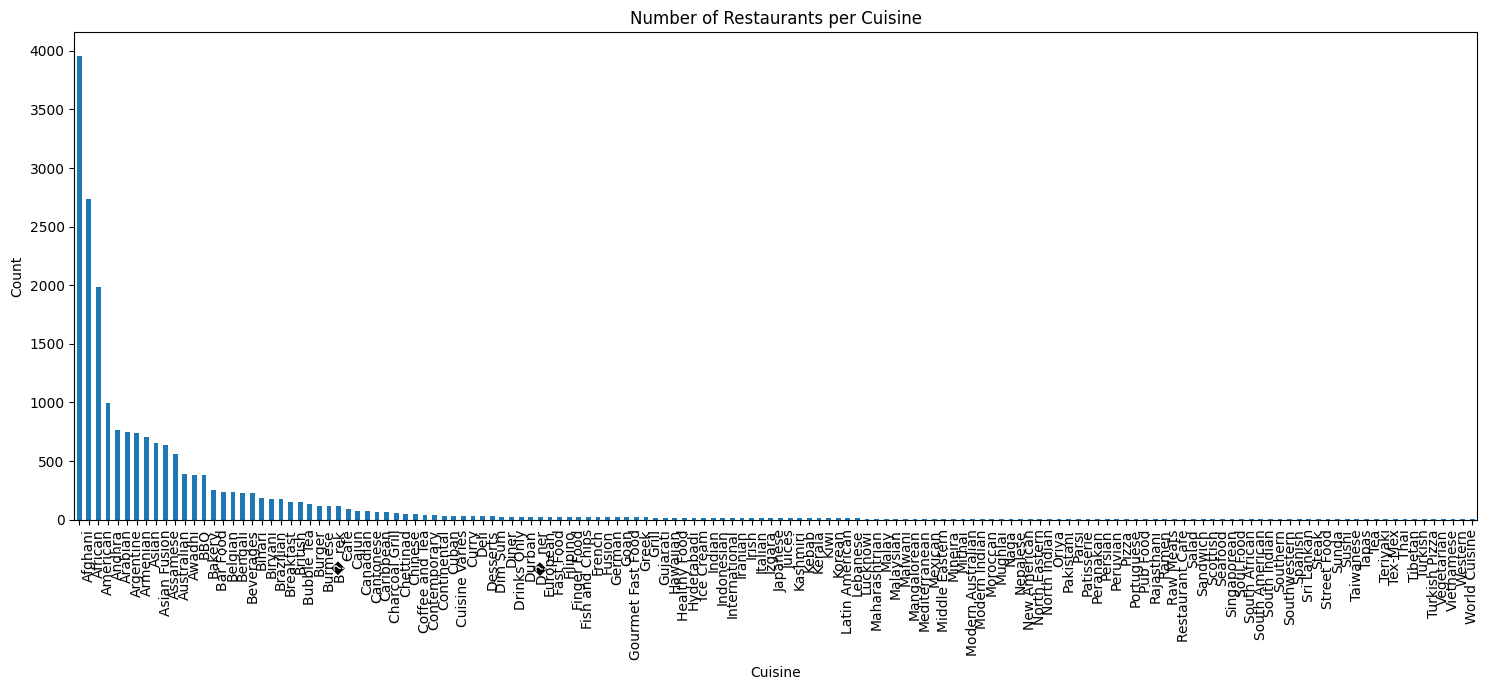

In [ ]:
# Task 3

# Data Preprocessing
restaurant_data = restaurent_data.copy()

# Split cuisines into lists and encode with MultiLabelBinarizer
restaurant_data['Cuisines_List'] = restaurant_data['Cuisines'].str.split(', ')
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(restaurant_data['Cuisines_List'])

# Select features and preprocess
features = ['City', 'Price range', 'Aggregate rating']
if 'Votes' in restaurant_data.columns:
    features.append('Votes')

X = restaurant_data[features]

# ColumnTransformer for feature preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('city', OneHotEncoder(handle_unknown='ignore'), ['City']),
        ('numeric', 'passthrough', ['Price range', 'Aggregate rating'] + (['Votes'] if 'Votes' in features else []))
    ])

X_processed = preprocessor.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Initialize and train the model (Random Forest)
model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Classification report and metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0))
print("\nHamming Loss:", hamming_loss(y_test, y_pred))
print("Exact Match Accuracy:", accuracy_score(y_test, y_pred))

# Analyze performance per cuisine
report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Identify poorly performing cuisines (F1-score < 0.5)
low_f1_cuisines = report_df[report_df['f1-score'] < 0.5].sort_values('f1-score')
print("\nCuisines with Low F1-Scores:")
print(low_f1_cuisines)

# Class distribution analysis
class_counts = pd.Series(y.sum(axis=0)).sort_values(ascending=False)
class_counts.index = mlb.classes_
print("\nTop 10 Cuisines by Count:")
print(class_counts.head(10))
print("\nBottom 10 Cuisines by Count:")
print(class_counts.tail(10))

# Visualize class distribution
plt.figure(figsize=(15, 7))
class_counts.plot(kind='bar')
plt.title('Number of Restaurants per Cuisine')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Summary of challenges/biases
print("\nKey Challenges and Biases:")
print("- **Class Imbalance**: Many cuisines have very few samples, leading to poor prediction accuracy.")
print("- **Feature Relevance**: Features like 'City' may not strongly correlate with niche cuisines.")
print("- **Label Overlap**: Restaurants with multiple cuisines complicate decision boundaries.")